This will be the line attractor that is meant to illustrate the simpliest case of loop switching, one layer. Will attempt to replicate the proposed tempo switching behavior in the Thaut tapping paper. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

In [3]:
class attractor:
    def __init__(self, n_units, exc_spread=1, inp_scale=1, exc_scale = 1, inh_scale = 1, dop_scale = 1):
        
        #number of units in the line
        self.n_units = n_units

        #the input weight matrix just scales the input up or down, allows for adjusting of excitation while still using intuitive inputs (I think)
        self.W_input = np.identity(n_units) * inp_scale

        #generates the internal excitatory weight matrix, exc_spread controls how far excitatory connections reach, exc_scale controls how strong the excitatory connections are
        #its just a collections of Gaussians, exc_spread controls the sd
        self.W_exc = np.zeros((n_units,n_units))
        unit_ids = np.arange(0,n_units,1)        
        for i in range(0,n_units):
            ###the multiplying by n_units is because it is a pdf that decreases with the number of units involved, there might be a smarter way around this 
            ###but not using a pdf does not work so I will keep moving for now, either way I am not sure it makes a difference
            self.W_exc[i] = stats.norm.pdf(unit_ids, i, exc_spread) * n_units * exc_scale
        
        #there is tonic inhibition that scales with the total amount of activity in the network, similar to the basal ganglia
        self.W_inh = np.ones((n_units,n_units)) * (-1 * inh_scale)

        #the dopamine modulates the excitatory current, this is how strong the modulation is
        self.dop_scale = dop_scale
        
        #just plotting the weights so they can be checked
        plt.figure(1)
        plt.imshow(self.W_exc, cmap="plasma")
        plt.colorbar()
        plt.title("W_exc matrix")

        plt.figure(2)
        plt.plot(self.W_exc[int(np.round(n_units/2,0))], color="steelblue")
        plt.title("Excitatory weights from unit "+str(int(np.round(n_units/2,0)))+" to all other units")
        plt.xlabel("Unit Number")
        plt.ylabel("Connection Strength")

        #just initializing these variables so I don't cause mistakes later due to not knowing how to code
        self.dopamine = 0
        self.input = 0
        self.simulation = 0        

    #simulates the attractor receiving the input 
    def run(self, input, dopamine):
        #storing these for later
        self.input = input
        self.dopamine = dopamine
        #number of time points and time constant
        n_steps = len(input[0])
        dt = 0.01

        #matrix to hold the activations of all the units
        activations = np.zeros((self.n_units, n_steps))
        

        for i in range(0, n_steps-1):
            activations[:,i+1] = activations[:,i] + dt * (self.non_lin(np.matmul(self.W_input,input[:,i]) + np.matmul(self.W_exc,activations[:,i]) * dopamine[i] * self.dop_scale + np.matmul(self.W_inh,activations[:,i])) - activations[:,i])
        

        self.simulation = activations 

        plt.figure(3)
        plt.imshow(input)
        plt.ylabel("unit")
        plt.xlabel("time")
        plt.colorbar()
        plt.title("Input")

        plt.figure(4)
        plt.imshow(activations[:,600:750])
        plt.ylabel("unit")
        plt.xlabel("time")
        plt.colorbar()
        plt.title("Activations of all units")


        #commenting these figures out for now, they are just adding clutter
        '''
        plt.figure(5)
        plt.title("activations of various units")
        for i in range(10):
            x = random.randint(0,self.n_units-1)
            plt.plot(activations[x], label="unit "+str(x), alpha=0.5)
        plt.legend()

        '''
        plt.figure(6)
        plt.title("Activations at certain steps")
        plt.plot(activations[:,int(n_steps/4)],label=str("Activations at time point "+str(int(n_steps/4))))
        plt.plot(activations[:,int(n_steps/2)],label=str("Activations at time point "+str(int(n_steps/2))))
        plt.plot(activations[:,int(n_steps/2)+int(n_steps/4)],label=str("Activations at time point "+str(int(n_steps/2)+int(n_steps/4))))
        plt.plot(activations[:,int(n_steps-1)],label=str("Activations at time point "+str(int(n_steps-1))))
        plt.ylabel("activation")
        plt.xlabel("unit")
        plt.legend()
        

        saliences = np.zeros(n_steps)
        for i in range(n_steps):
            saliences[i] = (np.argmax(activations[:,i]) + 400)/1000
        plt.figure(7)
        plt.plot(saliences[1:])
        plt.ylabel("most salient intertap interval")
        plt.xlabel("time")
        
        itis = np.zeros(40)
        itis[0]=saliences[100]
        last = 100
        for i in range(1,40):
            itis[i] = saliences[last+int(itis[i-1]/0.01)]
            last = last + int(itis[i-1]/0.01)
            
        plt.figure(8)
        plt.plot(itis,marker="o")
        plt.ylabel("Inter-tap interval")
        plt.xlabel("Stimuli Number")

    def non_lin(self, vec):
        
        vec = np.tanh(vec)
        for i in range(0,len(vec)):
            if vec[i] < 0:
                vec[i] = 0

        return vec

The below is the original first drafts of the attractor, not really fit to anything. But it shows that the concept works. I have changed the intial dt from 0.1 to 0.01 which means the attractors below are no longer balanced, other parameters will have to be modified in order for this to change. 

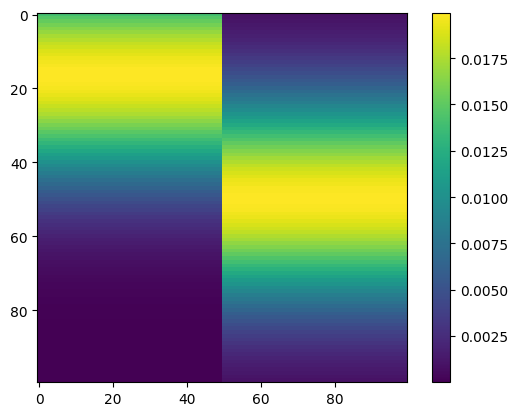

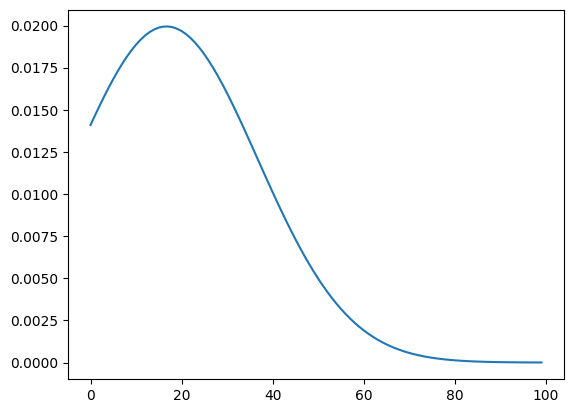

In [3]:
#going to create some input cases here to keep code clean

### case 1, simple Gaussian bump about a third of the way into the line
n_units = 100
n_steps = 50
sd = 20 
case1 = np.zeros((n_units,n_steps))

unit_ids = np.arange(0,100,1)
for i in range(0,n_steps):
    case1[:,i] = stats.norm.pdf(unit_ids, n_units/3, sd)

### case 2, simple gaussian bump that then jumps down the line, about a third
n_units = 100
n_steps = 100
sd = 20
case2 = np.zeros((n_units,n_steps))

unit_ids = np.arange(0,100,1)
for i in range(0,int(n_steps/2)):
    case2[:,i] = stats.norm.pdf(unit_ids, n_units/3, sd)
for i in range(int(n_steps/2),n_steps):
    case2[:,i] = stats.norm.pdf(unit_ids, n_units*(2/3)-10, sd)

### case 3, going to do the same as above, but have the jump be further so there is less overlap, I think it will help
n_units = 100
n_steps = 100
sd = 20
case3 = np.zeros((n_units,n_steps))

unit_ids = np.arange(0,100,1)
for i in range(0,int(n_steps/2)):
    case3[:,i] = stats.norm.pdf(unit_ids, n_units * 1/6, sd)
for i in range(int(n_steps/2),n_steps):
    case3[:,i] = stats.norm.pdf(unit_ids, n_units* 3/6, sd)   


plt.figure(1)
plt.imshow(case3)
plt.colorbar()

plt.figure(2)
plt.plot(case3[:,1])

I am going to leave this as unedited, as as far as I can tell, this is showing roughly what we can expect when there is shift and no decrease in dopamine. The intially activated loop "drags" the most activated up a little bit and yields an intermediete value. Then over time the inhibition brings the attractor to a steady state. 

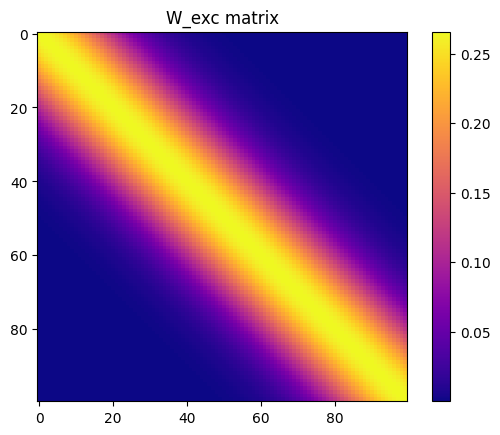

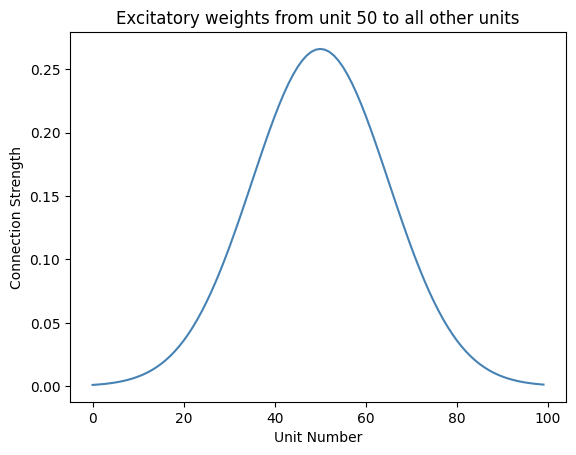

In [8]:
line = attractor(n_units = 100, exc_spread = 15, inp_scale = 5, exc_scale = 0.1, inh_scale = 1, dop_scale = 3)


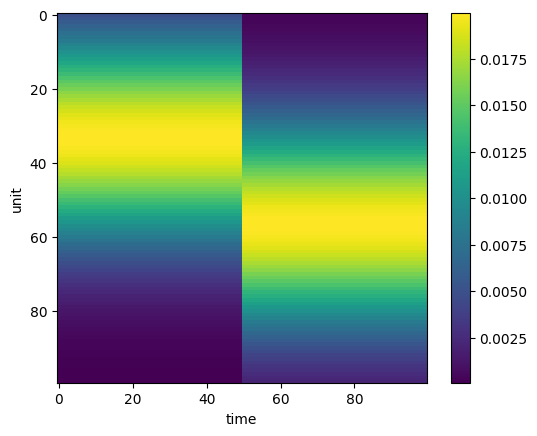

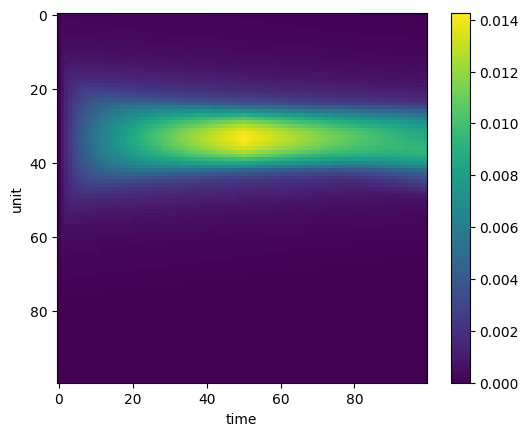

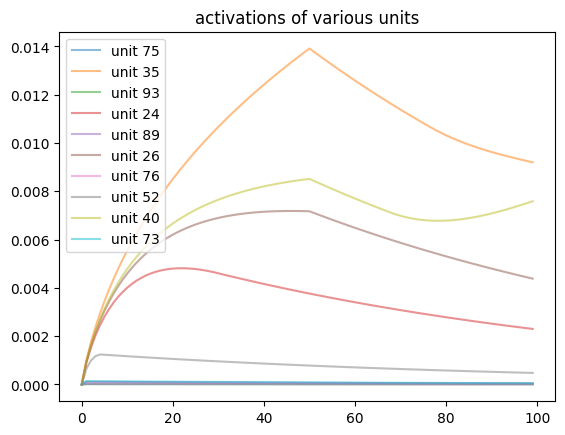

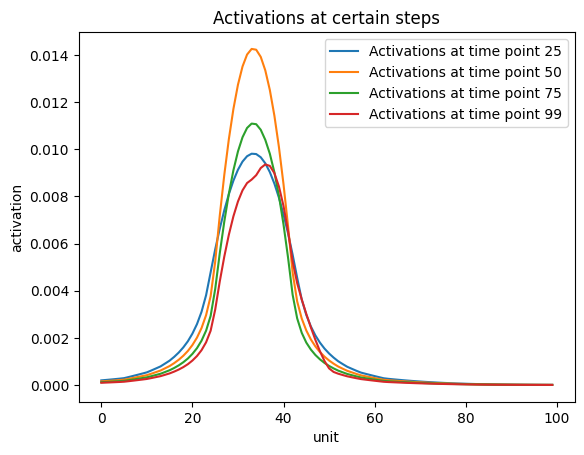

In [7]:
line.run(case2,np.ones(100))

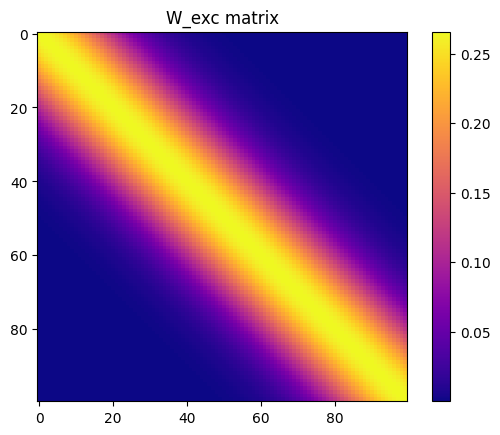

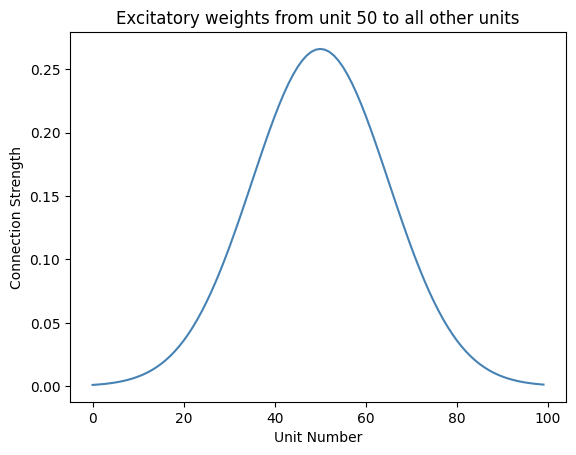

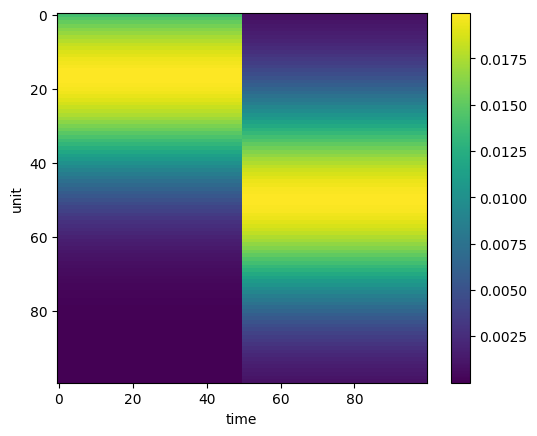

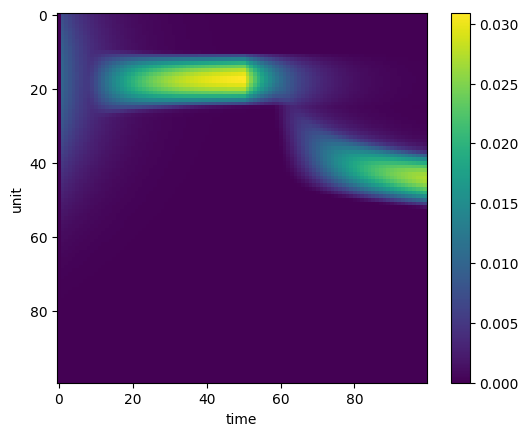

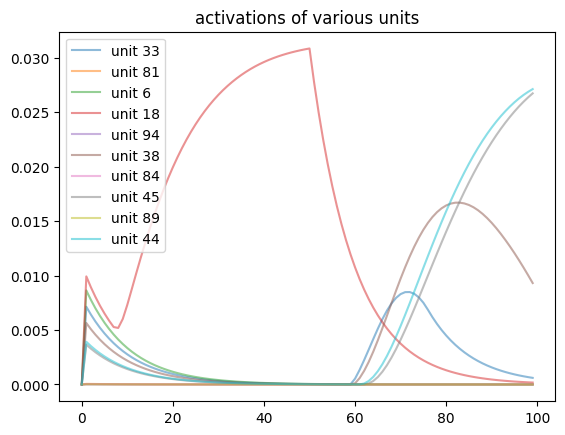

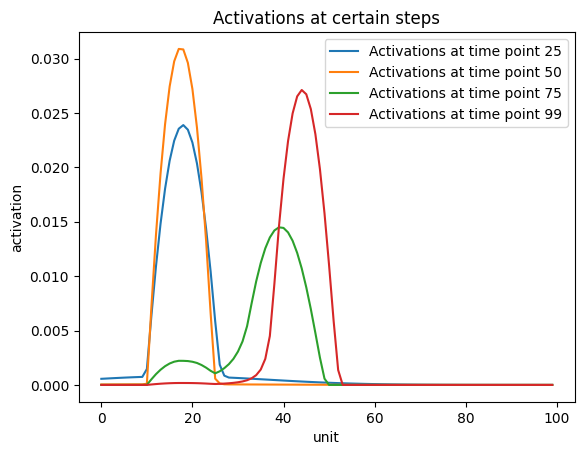

In [95]:
line2 = attractor(n_units = 100, exc_spread = 15, inp_scale = 5, exc_scale = 0.1, inh_scale = 1, dop_scale = 3)
dopamine = np.ones(100)
#dopamine[40:55] = 0
line2.run(case3,dopamine)

The below will be an attempt to replicate the exact graphs that the tapping study displayed. Thus the length of the simulation, ITIs encoded, and behaviour will all have to be fit.

We can first replicate the behavior when a small tempo change occurs, this is a shift from 500ms ISI to 510ms/490ms ISI. Just thinking about how I am going to graph the results, going to have to sample next ITI based on the current one I guess???

The ITIs are all between 400 and 600 ms, I guess we can use 200 units, representing 200 different ITIs each differing by 1 ms, probably a higher resolution than the real brain but it makes sense for now I think.

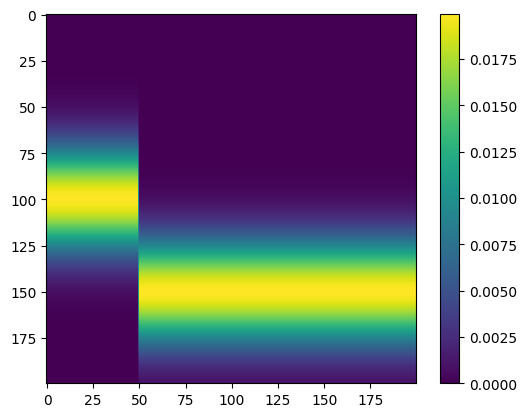

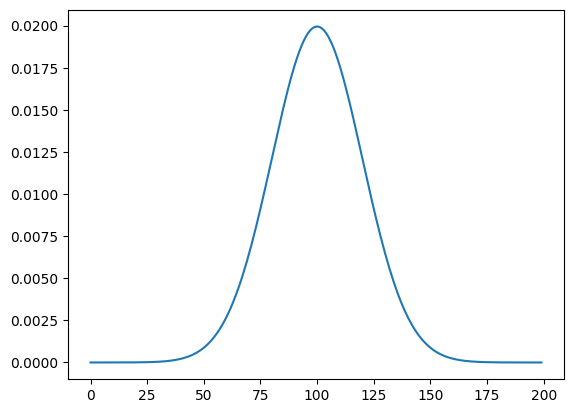

In [13]:
#ten taps at 500 ms, then 20 taps at 510 ms, with a 100 time step warm up time
fig4a_stim = np.zeros((200,2500))
#how sure are we of what tempo we want to tap along with?
sd = 20

unit_ids = np.arange(0,200,1)
for i in range(0,600):
    fig4a_stim[:,i] = stats.norm.pdf(unit_ids, 100, sd)

for i in range(600,2500):
    fig4a_stim[:,i] = stats.norm.pdf(unit_ids, 110, sd)

#ten taps at 500 ms, then 20 taps at 550ms, with a 100 time step warm up time
fig2a_stim = np.zeros((200,2500))
#how sure are we of what tempo we want to tap along with?
sd = 20

unit_ids = np.arange(0,200,1)
for i in range(0,600):
    fig2a_stim[:,i] = stats.norm.pdf(unit_ids, 100, sd)

for i in range(600,2500):
    fig2a_stim[:,i] = stats.norm.pdf(unit_ids, 150, sd)

#ten taps at 500 ms, then 20 taps at 520ms, with a 100 time step warm up time
fig3a_stim = np.zeros((200,2500))
#how sure are we of what tempo we want to tap along with?
sd = 20

unit_ids = np.arange(0,200,1)
for i in range(0,600):
    fig3a_stim[:,i] = stats.norm.pdf(unit_ids, 100, sd)

for i in range(600,2500):
    fig3a_stim[:,i] = stats.norm.pdf(unit_ids, 120, sd)

plt.figure(1)
plt.imshow(fig2a_stim[:,550:750])
plt.colorbar()

plt.figure(2)
plt.plot(fig3a_stim[:,1])

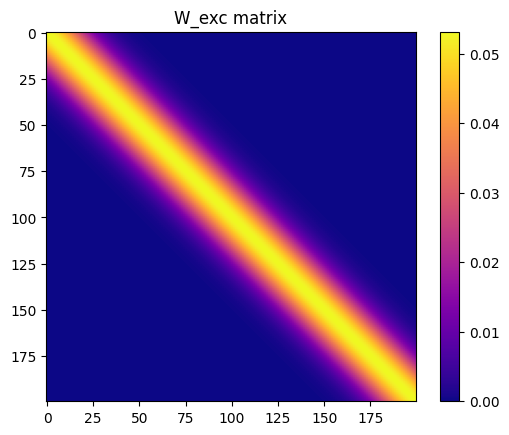

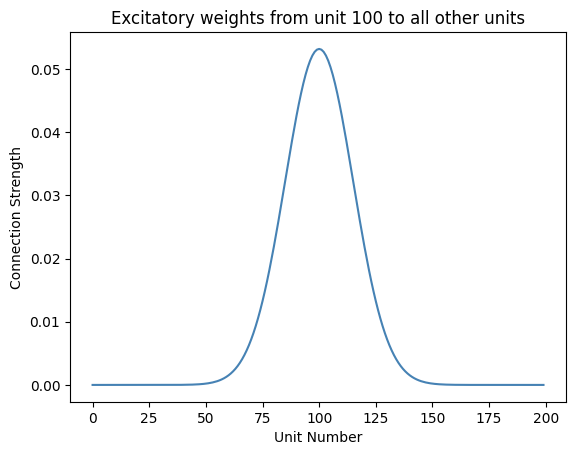

In [9]:
thaut = attractor(n_units = 200, exc_spread = 15, inp_scale = 25, exc_scale = 0.01, inh_scale = 1.4, dop_scale = 8)

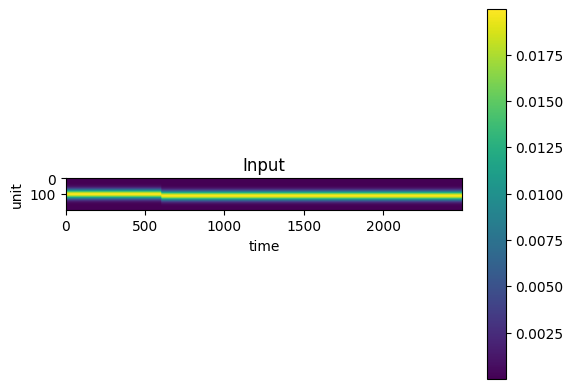

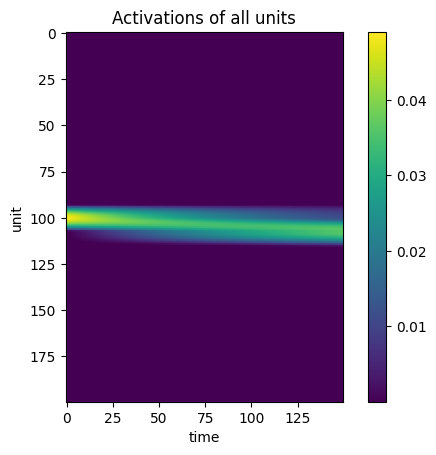

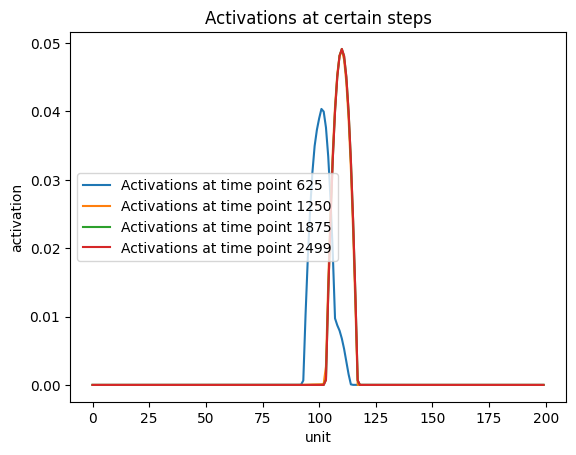

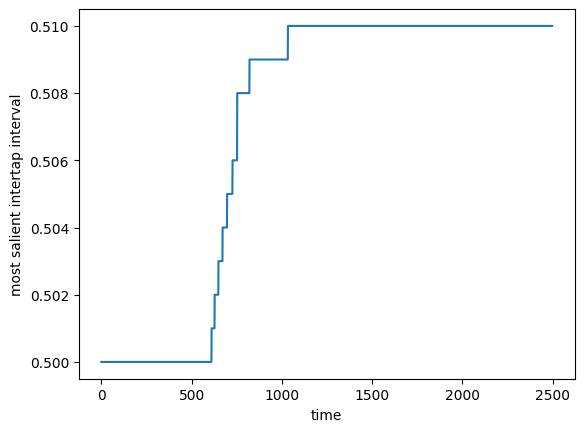

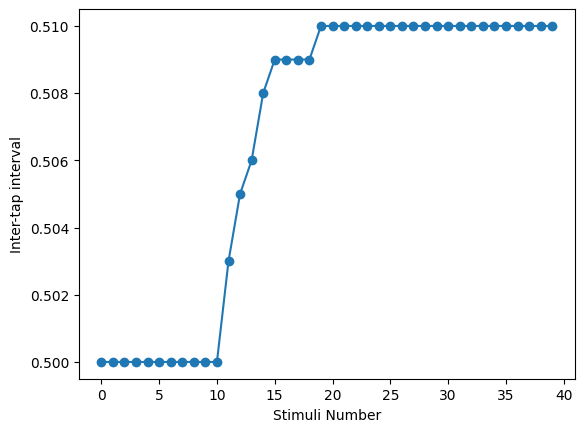

In [10]:
#lets assume to dopamine change is negligible for now, we can mess with it later but for now we won't 
dopamine4a = np.ones(2500)
thaut.run(input = fig4a_stim, dopamine = dopamine4a)

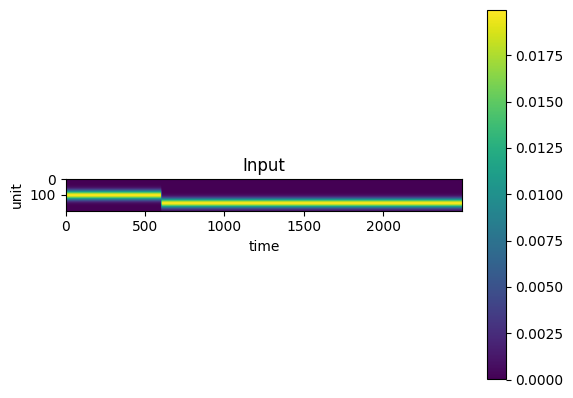

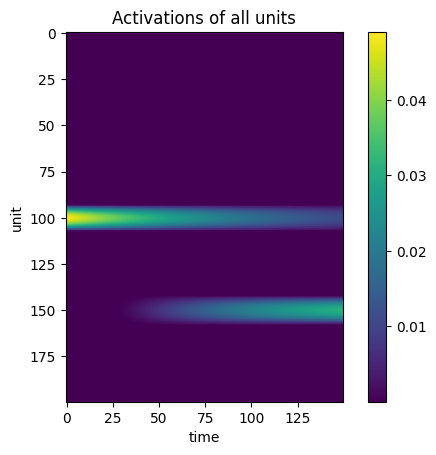

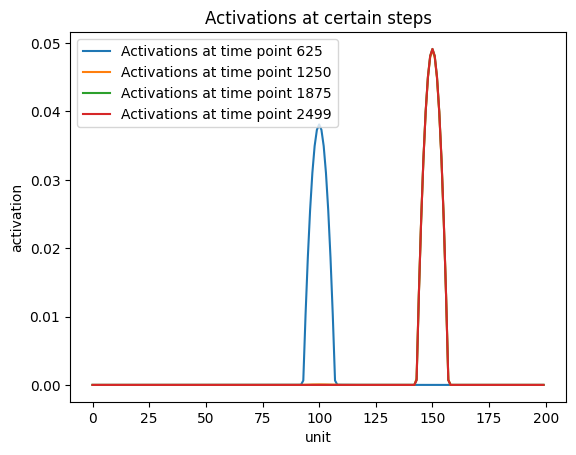

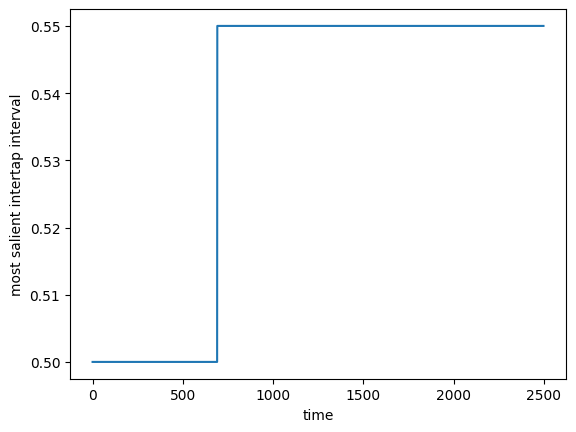

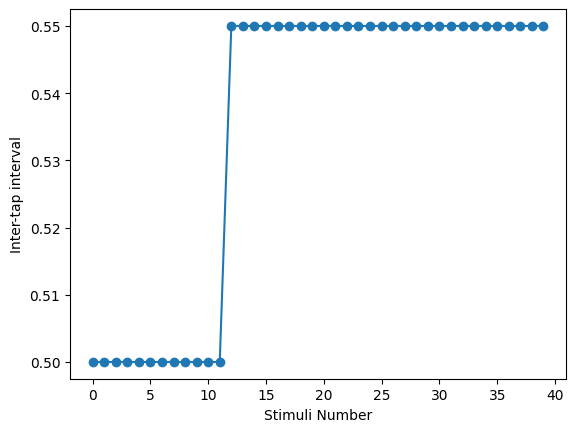

In [11]:
dopamine2a = np.ones(2500)
dopamine2a[500:510] = 0
thaut.run(input = fig2a_stim, dopamine = dopamine4a)

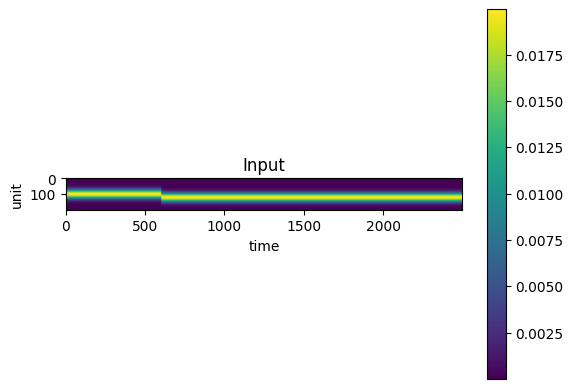

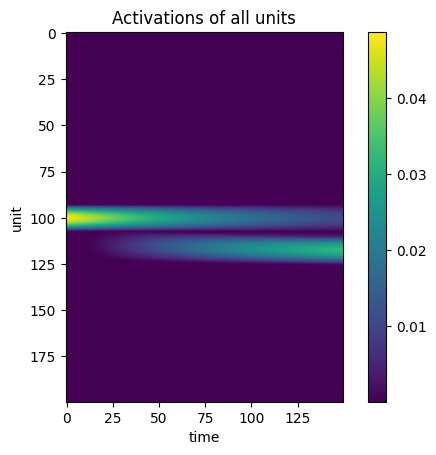

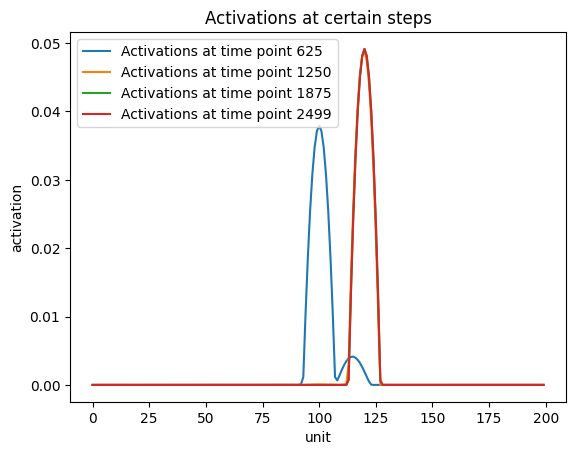

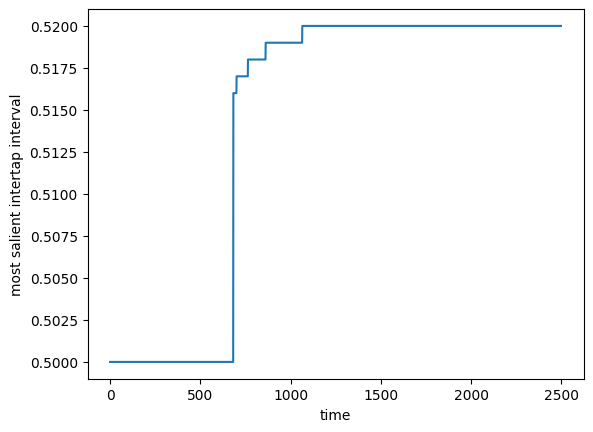

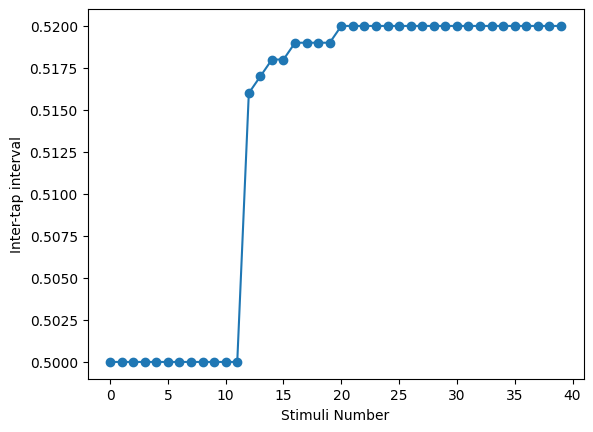

In [16]:
dopamine3a = np.ones(2500)
dopamine3a[500:510] = 0.8
thaut.run(input = fig3a_stim, dopamine = dopamine3a)